In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import pickle
import pyproj
import zipfile
import itertools
import xgboost as xg 
import math
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression, SelectKBest, mutual_info_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor




In [212]:
def model_val2(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    accuracy = model.score(x_test, y_test)
    print(f"{model} accuracy: {accuracy}")
    
    mse = mean_squared_error(y_test, y_pred)
    print(f"{model} mean squared error (MSE): {mse}")
    
    rmse = np.sqrt(mse)
    print(f"{model} root mean squared error (RMSE): {rmse}")

## Read Data

In [213]:
data = pd.read_csv("/kaggle/input/final-csv/final.csv")
data

,User ID,User Name,Driver Name,Car Condition,Weather,Traffic Condition,key,fare_amount,pickup_datetime,pickup_longitude,...,month,weekday,year,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist,distance,bearing
0,KHVrEVlD,Kimberly Adams,Amy Butler,Very Good,windy,Congested Traffic,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-1.288826,...,6,0,2009,20.265840,55.176046,14.342611,34.543548,27.572573,1.030764,-2.918897
1,lPxIuEri,Justin Tapia,Hannah Zimmerman,Excellent,cloudy,Flow Traffic,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-1.291824,...,1,1,2010,44.667679,31.832358,23.130775,15.125872,8.755732,8.450134,-0.375217
2,gsVN8JLS,Elizabeth Lopez,Amanda Jackson,Bad,stormy,Congested Traffic,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-1.291242,...,8,3,2011,43.597686,33.712082,19.865289,17.722624,9.847344,1.389525,2.599961
3,9I7kWFgd,Steven Wilson,Amy Horn,Very Good,stormy,Flow Traffic,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-1.291319,...,4,5,2012,42.642965,32.556289,21.063132,15.738963,7.703421,2.799270,0.133905
4,8QN5ZaGN,Alexander Andrews,Cassandra Larson,Bad,stormy,Congested Traffic,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-1.290987,...,3,1,2010,43.329953,39.406828,15.219339,23.732406,15.600745,1.999157,-0.502703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,er7Luy6J,Morgan Smith,Gabriel Coleman,Bad,rainy,Dense Traffic,2015-05-07 18:45:12.0000004,7.0,2015-05-07 18:45:12,-1.291173,...,5,3,2015,42.565403,36.580043,17.157511,20.401068,12.280187,1.404709,-2.275706
499996,FWDZu9NA,Dillon Jackson,Larry Richards,Very Good,rainy,Flow Traffic,2010-09-13 12:11:34.0000004,13.7,2010-09-13 12:11:34,-1.291595,...,9,0,2010,41.814877,27.833416,26.463167,8.596656,0.994796,0.994184,2.556931
499997,QZIMcpLZ,Michael Rodriguez,Lonnie Santana,Bad,rainy,Flow Traffic,2014-08-25 00:22:20.0000001,25.0,2014-08-25 00:22:20,-1.291262,...,8,0,2014,31.780108,38.960930,19.708214,19.066488,11.663395,7.859324,-1.926251
499998,AD72Uwmn,Deborah Soto,Emily Rivera,Good,stormy,Congested Traffic,2015-01-12 12:17:32.0000001,6.5,2015-01-12 12:17:32,-1.291101,...,1,0,2015,42.292914,36.382813,17.227166,20.006433,11.819775,0.994470,-0.384817


In [214]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   User ID            500000 non-null  object 
 1   User Name          500000 non-null  object 
 2   Driver Name        500000 non-null  object 
 3   Car Condition      500000 non-null  object 
 4   Weather            500000 non-null  object 
 5   Traffic Condition  500000 non-null  object 
 6   key                500000 non-null  object 
 7   fare_amount        500000 non-null  float64
 8   pickup_datetime    500000 non-null  object 
 9   pickup_longitude   500000 non-null  float64
 10  pickup_latitude    500000 non-null  float64
 11  dropoff_longitude  499995 non-null  float64
 12  dropoff_latitude   499995 non-null  float64
 13  passenger_count    500000 non-null  int64  
 14  hour               500000 non-null  int64  
 15  day                500000 non-null  int64  
 16  mo

In [215]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist,distance,bearing
count,500000.000000,500000.000000,500000.000000,499995.000000,499995.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000
mean,11.358361,-1.265712,0.696740,-1.265755,0.696675,1.683428,13.510834,15.684206,6.268650,3.042008,2011.739132,385.279367,380.503657,363.843772,363.674038,355.991423,19.468775,0.297145
std,9.916617,0.206941,0.140909,0.205903,0.128997,1.307395,6.511571,8.681066,3.437815,1.949240,1.860889,2419.087483,2428.804740,2425.075903,2428.348683,2428.730839,367.299601,1.804548
min,-44.900000,-52.119764,-54.389440,-59.049665,-44.676047,0.000000,0.000000,1.000000,1.000000,0.000000,2009.000000,1.017646,1.460945,0.382119,0.532545,0.080500,0.000000,-3.141593
25%,6.000000,-1.291405,0.710958,-1.291393,0.710943,1.000000,9.000000,8.000000,3.000000,1.000000,2010.000000,41.341514,32.173712,17.100762,14.886989,7.147384,1.214550,-0.854721
50%,8.500000,-1.291226,0.711268,-1.291197,0.711277,1.000000,14.000000,16.000000,6.000000,3.000000,2012.000000,42.523163,34.787507,19.591554,18.347580,10.458151,2.116970,-0.050442
75%,12.500000,-1.290970,0.711520,-1.290908,0.711538,2.000000,19.000000,23.000000,9.000000,5.000000,2013.000000,43.785649,38.304502,22.214815,22.417812,14.448699,3.890070,2.206769
max,500.000000,37.360538,29.724576,0.712985,7.061893,6.000000,23.000000,31.000000,12.000000,6.000000,2015.000000,30133.067880,30167.595967,30167.285794,30159.407296,30162.285356,12399.956433,3.141593


## Check Duplicates

In [216]:
data.duplicated().sum()

0

## Check NANs

In [217]:
data.isna().sum()

User ID              0
User Name            0
Driver Name          0
Car Condition        0
Weather              0
Traffic Condition    0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    5
dropoff_latitude     5
passenger_count      0
hour                 0
day                  0
month                0
weekday              0
year                 0
jfk_dist             5
ewr_dist             5
lga_dist             5
sol_dist             5
nyc_dist             5
distance             5
bearing              5
dtype: int64

In [218]:
data.dropna(subset=['dropoff_latitude'], inplace=True)

In [219]:
data.isna().sum()

User ID              0
User Name            0
Driver Name          0
Car Condition        0
Weather              0
Traffic Condition    0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
hour                 0
day                  0
month                0
weekday              0
year                 0
jfk_dist             0
ewr_dist             0
lga_dist             0
sol_dist             0
nyc_dist             0
distance             0
bearing              0
dtype: int64

In [220]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist,distance,bearing
count,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000
mean,11.358182,-1.265714,0.696742,-1.265755,0.696675,1.683445,13.510843,15.684239,6.268617,3.042020,2011.739129,385.279367,380.503657,363.843772,363.674038,355.991423,19.468775,0.297145
std,9.916069,0.206934,0.140906,0.205903,0.128997,1.307391,6.511596,8.681092,3.437798,1.949243,1.860897,2419.087483,2428.804740,2425.075903,2428.348683,2428.730839,367.299601,1.804548
min,-44.900000,-52.119764,-54.389440,-59.049665,-44.676047,0.000000,0.000000,1.000000,1.000000,0.000000,2009.000000,1.017646,1.460945,0.382119,0.532545,0.080500,0.000000,-3.141593
25%,6.000000,-1.291405,0.710958,-1.291393,0.710943,1.000000,9.000000,8.000000,3.000000,1.000000,2010.000000,41.341514,32.173712,17.100762,14.886989,7.147384,1.214550,-0.854721
50%,8.500000,-1.291226,0.711268,-1.291197,0.711277,1.000000,14.000000,16.000000,6.000000,3.000000,2012.000000,42.523163,34.787507,19.591554,18.347580,10.458151,2.116970,-0.050442
75%,12.500000,-1.290970,0.711520,-1.290908,0.711538,2.000000,19.000000,23.000000,9.000000,5.000000,2013.000000,43.785649,38.304502,22.214815,22.417812,14.448699,3.890070,2.206769
max,500.000000,37.360538,29.724576,0.712985,7.061893,6.000000,23.000000,31.000000,12.000000,6.000000,2015.000000,30133.067880,30167.595967,30167.285794,30159.407296,30162.285356,12399.956433,3.141593


In [221]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499995 entries, 0 to 499999
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   User ID            499995 non-null  object 
 1   User Name          499995 non-null  object 
 2   Driver Name        499995 non-null  object 
 3   Car Condition      499995 non-null  object 
 4   Weather            499995 non-null  object 
 5   Traffic Condition  499995 non-null  object 
 6   key                499995 non-null  object 
 7   fare_amount        499995 non-null  float64
 8   pickup_datetime    499995 non-null  object 
 9   pickup_longitude   499995 non-null  float64
 10  pickup_latitude    499995 non-null  float64
 11  dropoff_longitude  499995 non-null  float64
 12  dropoff_latitude   499995 non-null  float64
 13  passenger_count    499995 non-null  int64  
 14  hour               499995 non-null  int64  
 15  day                499995 non-null  int64  
 16  month  

In [222]:
data.reset_index(inplace=True, drop= True)

In [223]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499995 entries, 0 to 499994
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   User ID            499995 non-null  object 
 1   User Name          499995 non-null  object 
 2   Driver Name        499995 non-null  object 
 3   Car Condition      499995 non-null  object 
 4   Weather            499995 non-null  object 
 5   Traffic Condition  499995 non-null  object 
 6   key                499995 non-null  object 
 7   fare_amount        499995 non-null  float64
 8   pickup_datetime    499995 non-null  object 
 9   pickup_longitude   499995 non-null  float64
 10  pickup_latitude    499995 non-null  float64
 11  dropoff_longitude  499995 non-null  float64
 12  dropoff_latitude   499995 non-null  float64
 13  passenger_count    499995 non-null  int64  
 14  hour               499995 non-null  int64  
 15  day                499995 non-null  int64  
 16  mo

In [224]:
data.drop(axis= 1, columns= "key", inplace= True)

## Drop useless cols

In [225]:
data.drop(columns=["pickup_datetime", "User ID", "User Name", "Driver Name"], axis=1, inplace=True)

In [226]:
data

,Car Condition,Weather,Traffic Condition,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,...,month,weekday,year,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist,distance,bearing
0,Very Good,windy,Congested Traffic,4.5,-1.288826,0.710721,-1.288779,0.710563,1,17,...,6,0,2009,20.265840,55.176046,14.342611,34.543548,27.572573,1.030764,-2.918897
1,Excellent,cloudy,Flow Traffic,16.9,-1.291824,0.710546,-1.291182,0.711780,1,16,...,1,1,2010,44.667679,31.832358,23.130775,15.125872,8.755732,8.450134,-0.375217
2,Bad,stormy,Congested Traffic,5.7,-1.291242,0.711418,-1.291391,0.711231,2,0,...,8,3,2011,43.597686,33.712082,19.865289,17.722624,9.847344,1.389525,2.599961
3,Very Good,stormy,Flow Traffic,7.7,-1.291319,0.710927,-1.291396,0.711363,1,4,...,4,5,2012,42.642965,32.556289,21.063132,15.738963,7.703421,2.799270,0.133905
4,Bad,stormy,Congested Traffic,5.3,-1.290987,0.711536,-1.290787,0.711811,1,7,...,3,1,2010,43.329953,39.406828,15.219339,23.732406,15.600745,1.999157,-0.502703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499990,Bad,rainy,Dense Traffic,7.0,-1.291173,0.711514,-1.290951,0.711371,1,18,...,5,3,2015,42.565403,36.580043,17.157511,20.401068,12.280187,1.404709,-2.275706
499991,Very Good,rainy,Flow Traffic,13.7,-1.291595,0.710670,-1.291708,0.710540,1,12,...,9,0,2010,41.814877,27.833416,26.463167,8.596656,0.994796,0.994184,2.556931
499992,Bad,rainy,Flow Traffic,25.0,-1.291262,0.710796,-1.289737,0.710366,1,0,...,8,0,2014,31.780108,38.960930,19.708214,19.066488,11.663395,7.859324,-1.926251
499993,Good,stormy,Congested Traffic,6.5,-1.291101,0.711335,-1.291023,0.711480,6,12,...,1,0,2015,42.292914,36.382813,17.227166,20.006433,11.819775,0.994470,-0.384817


In [227]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499995 entries, 0 to 499994
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Car Condition      499995 non-null  object 
 1   Weather            499995 non-null  object 
 2   Traffic Condition  499995 non-null  object 
 3   fare_amount        499995 non-null  float64
 4   pickup_longitude   499995 non-null  float64
 5   pickup_latitude    499995 non-null  float64
 6   dropoff_longitude  499995 non-null  float64
 7   dropoff_latitude   499995 non-null  float64
 8   passenger_count    499995 non-null  int64  
 9   hour               499995 non-null  int64  
 10  day                499995 non-null  int64  
 11  month              499995 non-null  int64  
 12  weekday            499995 non-null  int64  
 13  year               499995 non-null  int64  
 14  jfk_dist           499995 non-null  float64
 15  ewr_dist           499995 non-null  float64
 16  lg

## BoxPlot

<Figure size 1000x500 with 0 Axes>

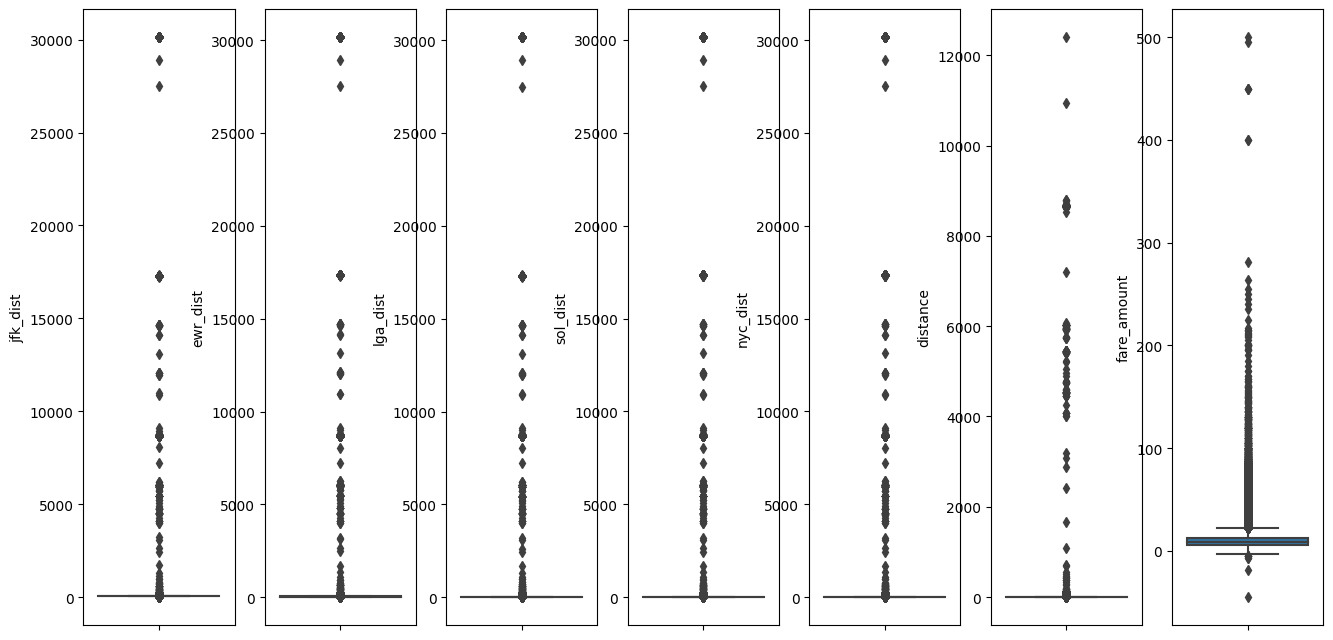

In [228]:
plt.figure(figsize=(10,5))
fig, ax = plt.subplots(1,7, sharex=True, figsize=(16,8))

sns.boxplot(ax= ax[0], y= "jfk_dist", data= data)
sns.boxplot(ax= ax[1], y= "ewr_dist", data= data)
sns.boxplot(ax= ax[2], y= "lga_dist", data= data)
sns.boxplot(ax= ax[3], y= "sol_dist", data= data)
sns.boxplot(ax= ax[4], y= "nyc_dist", data= data)
sns.boxplot(ax= ax[5], y= "distance", data= data)
sns.boxplot(ax= ax[6], y= "fare_amount", data= data)



plt.show()

In [229]:
def radian_to_decimal(radian):
    return radian * (180.0 / math.pi)


col = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
for i in col:
    data[i] = data[i].map(radian_to_decimal)

In [230]:
#Problem
df10= data[(data["pickup_longitude"] != 0) & (data["distance"] == 0)]
df10

,Car Condition,Weather,Traffic Condition,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,...,month,weekday,year,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist,distance,bearing
105,Very Good,sunny,Flow Traffic,52.0,-74.035839,40.747320,-74.035839,40.747320,1,0,...,3,2,2009,49.494963,25.484177,28.288925,13.007479,8.887757,0.0,0.0
191,Bad,rainy,Flow Traffic,6.5,-73.998488,40.726303,-73.998488,40.726303,1,21,...,1,2,2014,41.740514,29.647805,24.043458,11.324847,3.009646,0.0,0.0
270,Excellent,stormy,Congested Traffic,7.5,-73.995892,40.746454,-73.995892,40.746454,1,1,...,8,5,2012,43.615226,31.487907,21.866254,15.141007,7.395066,0.0,0.0
290,Good,rainy,Dense Traffic,6.9,-73.982432,40.745747,-73.982432,40.745747,1,12,...,12,0,2009,41.640352,33.540891,19.781085,16.358368,8.100905,0.0,0.0
396,Bad,sunny,Congested Traffic,12.0,-73.844904,40.736318,-73.844904,40.736318,1,18,...,3,2,2014,24.195068,55.428910,10.229722,35.239662,27.658491,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499561,Bad,windy,Dense Traffic,4.5,-73.965385,40.759243,-73.965385,40.759243,1,15,...,5,3,2011,41.173008,37.328743,16.130773,20.504513,12.175059,0.0,0.0
499570,Bad,sunny,Congested Traffic,7.3,-73.977893,40.756397,-73.977893,40.756397,1,11,...,4,1,2012,42.415661,35.144418,18.329241,18.690862,10.547997,0.0,0.0
499585,Very Good,windy,Dense Traffic,3.0,-73.985299,40.760519,-73.985299,40.760519,1,15,...,3,2,2014,43.963394,34.398816,19.340967,18.738001,10.903674,0.0,0.0
499698,Good,sunny,Congested Traffic,7.7,-73.850235,40.733578,-73.850235,40.733578,1,8,...,7,0,2011,24.091947,54.440044,10.418063,34.202570,26.670011,0.0,0.0


In [231]:
data= data.drop(df10.index)

In [232]:
data = data[(data.pickup_latitude<90) & (data.dropoff_latitude<90) &
        (data.pickup_latitude>-90) & (data.dropoff_latitude>-90) &
        (data.pickup_longitude<180) & (data.dropoff_longitude<180) &
        (data.pickup_longitude>-180) & (data.dropoff_longitude>-180)]
data

,Car Condition,Weather,Traffic Condition,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,...,month,weekday,year,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist,distance,bearing
0,Very Good,windy,Congested Traffic,4.5,-73.844311,40.721319,-73.841610,40.712278,1,17,...,6,0,2009,20.265840,55.176046,14.342611,34.543548,27.572573,1.030764,-2.918897
1,Excellent,cloudy,Flow Traffic,16.9,-74.016048,40.711303,-73.979268,40.782004,1,16,...,1,1,2010,44.667679,31.832358,23.130775,15.125872,8.755732,8.450134,-0.375217
2,Bad,stormy,Congested Traffic,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0,...,8,3,2011,43.597686,33.712082,19.865289,17.722624,9.847344,1.389525,2.599961
3,Very Good,stormy,Flow Traffic,7.7,-73.987130,40.733143,-73.991567,40.758092,1,4,...,4,5,2012,42.642965,32.556289,21.063132,15.738963,7.703421,2.799270,0.133905
4,Bad,stormy,Congested Traffic,5.3,-73.968095,40.768008,-73.956655,40.783762,1,7,...,3,1,2010,43.329953,39.406828,15.219339,23.732406,15.600745,1.999157,-0.502703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499990,Bad,rainy,Dense Traffic,7.0,-73.978775,40.766724,-73.966072,40.758537,1,18,...,5,3,2015,42.565403,36.580043,17.157511,20.401068,12.280187,1.404709,-2.275706
499991,Very Good,rainy,Flow Traffic,13.7,-74.002932,40.718408,-74.009442,40.710952,1,12,...,9,0,2010,41.814877,27.833416,26.463167,8.596656,0.994796,0.994184,2.556931
499992,Bad,rainy,Flow Traffic,25.0,-73.983885,40.725611,-73.896482,40.700980,1,0,...,8,0,2014,31.780108,38.960930,19.708214,19.066488,11.663395,7.859324,-1.926251
499993,Good,stormy,Congested Traffic,6.5,-73.974617,40.756512,-73.970184,40.764801,6,12,...,1,0,2015,42.292914,36.382813,17.227166,20.006433,11.819775,0.994470,-0.384817


In [233]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist,distance,bearing
count,494720.000000,494720.000000,494720.000000,494720.000000,494720.000000,494720.000000,494720.000000,494720.000000,494720.000000,494720.000000,494720.000000,494720.000000,494720.000000,494720.000000,494720.000000,494720.000000,494720.000000,494720.000000
mean,11.359968,-72.496046,39.914415,-72.492252,39.913489,1.683587,13.511726,15.683383,6.269265,3.042086,2011.743904,388.534544,383.726727,367.085218,366.893565,359.206068,19.516774,0.300331
std,9.828827,10.467991,6.131329,10.476746,6.135741,1.307440,6.512819,8.681726,3.438208,1.949113,1.862039,2430.317982,2440.092714,2436.339350,2439.633353,2440.017620,367.765786,1.813848
min,-44.900000,-128.175950,-74.016195,-121.391248,-74.035197,0.000000,0.000000,1.000000,1.000000,0.000000,2009.000000,1.017646,1.460945,0.382119,0.532545,0.143207,0.000000,-3.141593
25%,6.000000,-73.992057,40.734928,-73.991386,40.734062,1.000000,9.000000,8.000000,3.000000,1.000000,2010.000000,41.350946,32.172299,17.111364,14.883261,7.142505,1.239000,-0.869530
50%,8.500000,-73.981817,40.752673,-73.980156,40.753162,1.000000,14.000000,16.000000,6.000000,3.000000,2012.000000,42.525473,34.778971,19.592770,18.336093,10.444133,2.140699,-0.079073
75%,12.500000,-73.967264,40.767078,-73.963713,40.768143,2.000000,19.000000,23.000000,9.000000,5.000000,2013.000000,43.782654,38.282096,22.208884,22.398139,14.427159,3.920530,2.224252
max,495.000000,40.812887,69.400000,40.851027,73.997265,6.000000,23.000000,31.000000,12.000000,6.000000,2015.000000,30133.067880,30167.595967,30167.285794,30159.407296,30162.285356,8786.235625,3.141593


In [234]:
q1= data["distance"].quantile(.25)
q3= data["distance"].quantile(.75)

IQR= q3 - q1

lower_bound_dist= q1 - 1.5 * IQR
upper_bound_dist= q3 + 1.5 * IQR

In [235]:
q1= data["jfk_dist"].quantile(.25)
q3= data["jfk_dist"].quantile(.75)

IQR= q3 - q1

lower_bound_jfk= q1 - 1.5 * IQR
upper_bound_jfk= q3 + 1.5 * IQR

In [236]:
q1= data["ewr_dist"].quantile(.25)
q3= data["ewr_dist"].quantile(.75)

IQR= q3 - q1

lower_bound_ewr= q1 - 1.5 * IQR
upper_bound_ewr= q3 + 1.5 * IQR

In [237]:
q1= data["lga_dist"].quantile(.25)
q3= data["lga_dist"].quantile(.75)

IQR= q3 - q1

lower_bound_lga= q1 - 1.5 * IQR
upper_bound_lga= q3 + 1.5 * IQR

In [238]:
q1= data["sol_dist"].quantile(.25)
q3= data["sol_dist"].quantile(.75)

IQR= q3 - q1

lower_bound_sol= q1 - 1.5 * IQR
upper_bound_sol= q3 + 1.5 * IQR

In [239]:
q1= data["nyc_dist"].quantile(.25)
q3= data["nyc_dist"].quantile(.75)

IQR= q3 - q1

lower_bound_nyc= q1 - 1.5 * IQR
upper_bound_nyc= q3 + 1.5 * IQR

In [240]:
q1= data["fare_amount"].quantile(.25)
q3= data["fare_amount"].quantile(.75)

IQR= q3 - q1

lower_bound_amount= q1 - 1.5 * IQR
upper_bound_amount= q3 + 1.5 * IQR

In [241]:
q1= data["bearing"].quantile(.25)
q3= data["bearing"].quantile(.75)

IQR= q3 - q1

lower_bound_bearing= q1 - 1.5 * IQR
upper_bound_bearing= q3 + 1.5 * IQR

In [242]:
df3= data[   ((data["distance"] > upper_bound_dist) | (data["distance"] < lower_bound_dist)) |
        ((data["jfk_dist"] > upper_bound_jfk) | (data["jfk_dist"] < lower_bound_jfk)) |
        ((data["ewr_dist"] > upper_bound_ewr) | (data["ewr_dist"] < lower_bound_ewr)) |
        ((data["lga_dist"] > upper_bound_lga) | (data["lga_dist"] < lower_bound_lga)) |
        ((data["sol_dist"] > upper_bound_sol) | (data["sol_dist"] < lower_bound_sol)) |
        ((data["nyc_dist"] > upper_bound_nyc) | (data["nyc_dist"] < lower_bound_nyc)) |
        ((data["fare_amount"] > upper_bound_amount) | (data["fare_amount"] < lower_bound_amount)) |
        ((data["bearing"] > upper_bound_bearing) | (data["bearing"] < lower_bound_bearing)) 
        ]

df3

,Car Condition,Weather,Traffic Condition,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,...,month,weekday,year,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist,distance,bearing
0,Very Good,windy,Congested Traffic,4.5,-73.844311,40.721319,-73.841610,40.712278,1,17,...,6,0,2009,20.265840,55.176046,14.342611,34.543548,27.572573,1.030764,-2.918897
1,Excellent,cloudy,Flow Traffic,16.9,-74.016048,40.711303,-73.979268,40.782004,1,16,...,1,1,2010,44.667679,31.832358,23.130775,15.125872,8.755732,8.450134,-0.375217
11,Bad,rainy,Dense Traffic,5.5,0.000000,0.000000,0.000000,0.000000,3,11,...,12,0,2012,17293.486312,17360.264559,17314.695444,17339.554005,17334.256605,0.000000,0.000000
15,Excellent,windy,Dense Traffic,5.0,0.000000,0.000000,0.000000,0.000000,1,12,...,11,5,2013,17293.486312,17360.264559,17314.695444,17339.554005,17334.256605,0.000000,0.000000
26,Good,cloudy,Congested Traffic,6.5,0.000000,0.000000,0.000000,0.000000,1,20,...,2,0,2011,17293.486312,17360.264559,17314.695444,17339.554005,17334.256605,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499974,Good,cloudy,Congested Traffic,49.8,-73.872878,40.773927,-74.014845,40.714322,1,14,...,12,0,2012,38.453473,39.699129,14.245860,21.007872,13.776808,13.673645,2.076021
499975,Bad,windy,Flow Traffic,18.1,-73.965803,40.758606,-73.871488,40.774361,1,13,...,5,4,2009,37.451586,45.242562,8.452198,27.559217,19.198486,8.133781,-1.353175
499976,Very Good,sunny,Dense Traffic,8.1,-73.993462,40.682315,-73.977465,40.666637,5,22,...,5,6,2009,35.725725,31.184548,29.812129,10.555732,9.526175,2.204347,-2.482906
499988,Bad,rainy,Flow Traffic,19.5,-73.948728,40.782021,-73.881287,40.737874,1,2,...,2,0,2013,35.253546,45.766942,10.869932,27.883807,19.840035,7.507478,-2.283101


In [243]:
data= data.drop(df3.index)

In [244]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist,distance,bearing
count,412287.000000,412287.000000,412287.000000,412287.000000,412287.000000,412287.000000,412287.000000,412287.000000,412287.000000,412287.000000,412287.000000,412287.000000,412287.000000,412287.000000,412287.000000,412287.000000,412287.000000,412287.000000
mean,8.701100,-73.981974,40.752682,-73.980948,40.753092,1.678709,13.671023,15.675352,6.253421,3.024740,2011.709896,42.743550,34.494323,19.567882,17.853698,9.940214,2.379507,0.367972
std,3.876461,0.016137,0.020914,0.017232,0.022364,1.303649,6.358845,8.681149,3.445300,1.939684,1.861962,1.628044,3.499437,3.167252,4.410577,4.253798,1.570100,1.824975
min,-3.000000,-74.066947,40.658510,-74.051242,40.655895,0.000000,0.000000,1.000000,1.000000,0.000000,2009.000000,37.703444,23.879516,9.511024,5.426219,0.143207,0.000084,-3.141532
25%,5.700000,-73.992920,40.738572,-73.992338,40.738746,1.000000,9.000000,8.000000,3.000000,1.000000,2010.000000,41.707578,31.832623,17.306022,14.546592,6.648423,1.205812,-0.790014
50%,7.700000,-73.982982,40.753715,-73.982216,40.754494,1.000000,14.000000,16.000000,6.000000,3.000000,2012.000000,42.640320,34.178713,19.510662,17.744660,9.743698,1.948698,-0.085458
75%,10.900000,-73.971809,40.766427,-73.970904,40.767362,2.000000,19.000000,23.000000,9.000000,5.000000,2013.000000,43.723116,37.044453,21.828737,21.124891,13.089510,3.157304,2.348133
max,22.200000,-73.885295,40.842248,-73.885232,40.843367,6.000000,23.000000,31.000000,12.000000,6.000000,2015.000000,47.429995,47.439352,29.842431,33.109956,25.093386,7.942800,3.141593


## Bobplot After Dropping

<Figure size 1000x500 with 0 Axes>

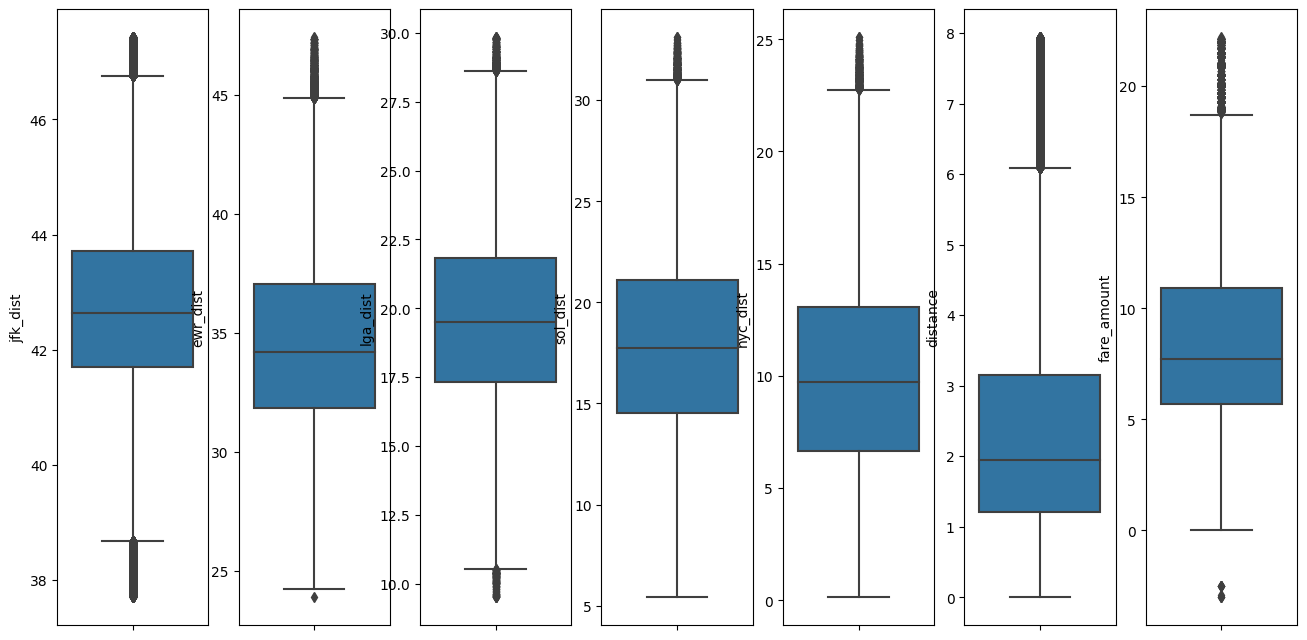

In [245]:
plt.figure(figsize=(10,5))
fig, ax = plt.subplots(1,7, sharex=True, figsize=(16,8))


sns.boxplot(ax= ax[0], y= "jfk_dist", data= data)
sns.boxplot(ax= ax[1], y= "ewr_dist", data= data)
sns.boxplot(ax= ax[2], y= "lga_dist", data= data)
sns.boxplot(ax= ax[3], y= "sol_dist", data= data)
sns.boxplot(ax= ax[4], y= "nyc_dist", data= data)
sns.boxplot(ax= ax[5], y= "distance", data= data)
sns.boxplot(ax= ax[6], y= "fare_amount", data= data)



plt.show()

In [246]:
data.reset_index(inplace=True, drop= True)

In [247]:
data

,Car Condition,Weather,Traffic Condition,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,...,month,weekday,year,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist,distance,bearing
0,Bad,stormy,Congested Traffic,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0,...,8,3,2011,43.597686,33.712082,19.865289,17.722624,9.847344,1.389525,2.599961
1,Very Good,stormy,Flow Traffic,7.7,-73.987130,40.733143,-73.991567,40.758092,1,4,...,4,5,2012,42.642965,32.556289,21.063132,15.738963,7.703421,2.799270,0.133905
2,Bad,stormy,Congested Traffic,5.3,-73.968095,40.768008,-73.956655,40.783762,1,7,...,3,1,2010,43.329953,39.406828,15.219339,23.732406,15.600745,1.999157,-0.502703
3,Excellent,sunny,Congested Traffic,12.1,-74.000964,40.731630,-73.972892,40.758233,1,9,...,1,3,2011,42.335622,32.824930,20.648176,15.741133,7.649541,3.787239,-0.674251
4,Excellent,windy,Flow Traffic,7.5,-73.980002,40.751662,-73.973802,40.764842,1,20,...,11,1,2012,42.563234,35.482608,18.113693,19.126670,10.993150,1.555807,-0.342260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412282,Very Good,windy,Congested Traffic,13.0,-73.988174,40.748348,-73.987244,40.738884,5,22,...,1,5,2015,42.123722,32.557909,20.805410,15.446574,7.285943,1.055295,-3.067213
412283,Bad,rainy,Dense Traffic,7.0,-73.978775,40.766724,-73.966072,40.758537,1,18,...,5,3,2015,42.565403,36.580043,17.157511,20.401068,12.280187,1.404709,-2.275706
412284,Very Good,rainy,Flow Traffic,13.7,-74.002932,40.718408,-74.009442,40.710952,1,12,...,9,0,2010,41.814877,27.833416,26.463167,8.596656,0.994796,0.994184,2.556931
412285,Good,stormy,Congested Traffic,6.5,-73.974617,40.756512,-73.970184,40.764801,6,12,...,1,0,2015,42.292914,36.382813,17.227166,20.006433,11.819775,0.994470,-0.384817


## Count Plot

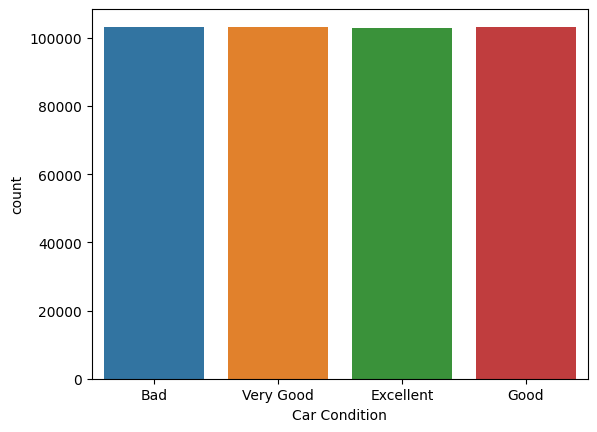

In [248]:
sns.countplot(x= data["Car Condition"])
plt.show()

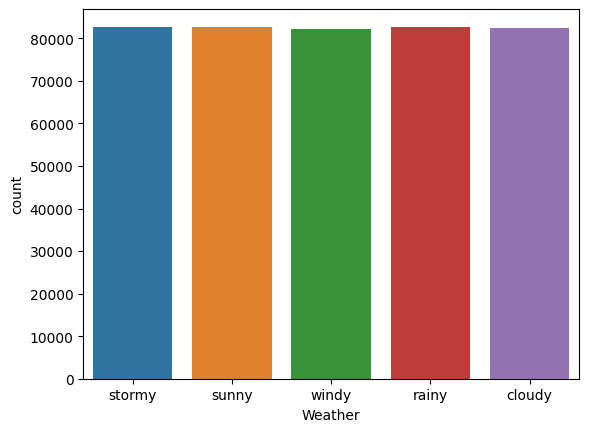

In [249]:
sns.countplot(x= data["Weather"])
plt.show()

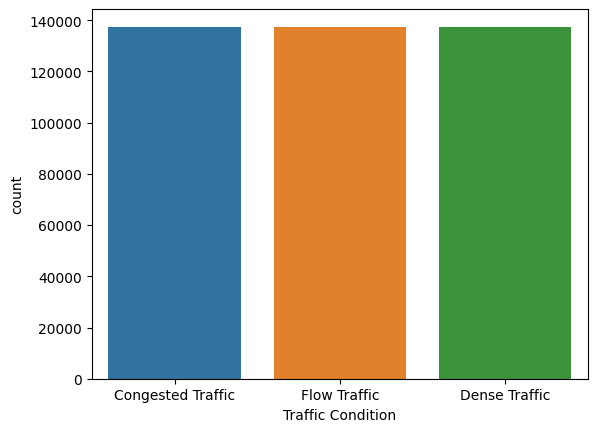

In [250]:
sns.countplot(x= data["Traffic Condition"])
plt.show()

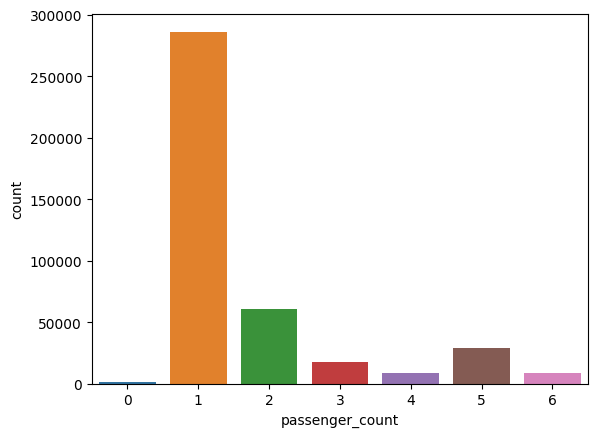

In [251]:
sns.countplot(x= data["passenger_count"])
plt.show()

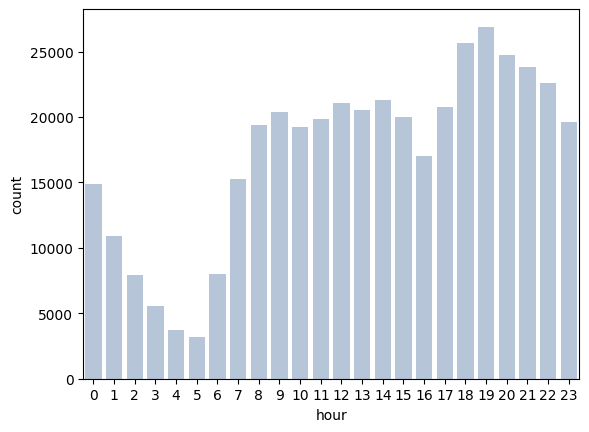

In [252]:
sns.countplot(x= data["hour"], color= "lightsteelblue")
plt.show()

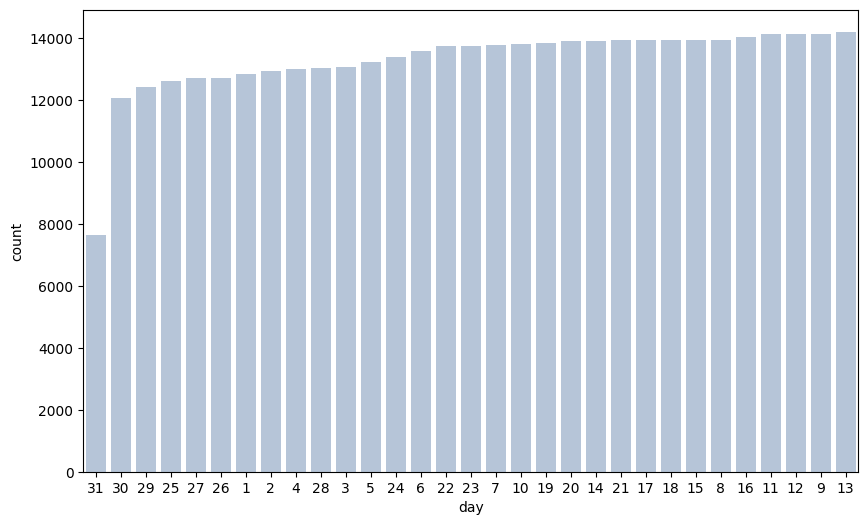

In [253]:
plt.figure(figsize=(10,6))
sns.countplot(x= data["day"], color= "lightsteelblue", order=data['day'].value_counts(ascending=True).index)
plt.show()

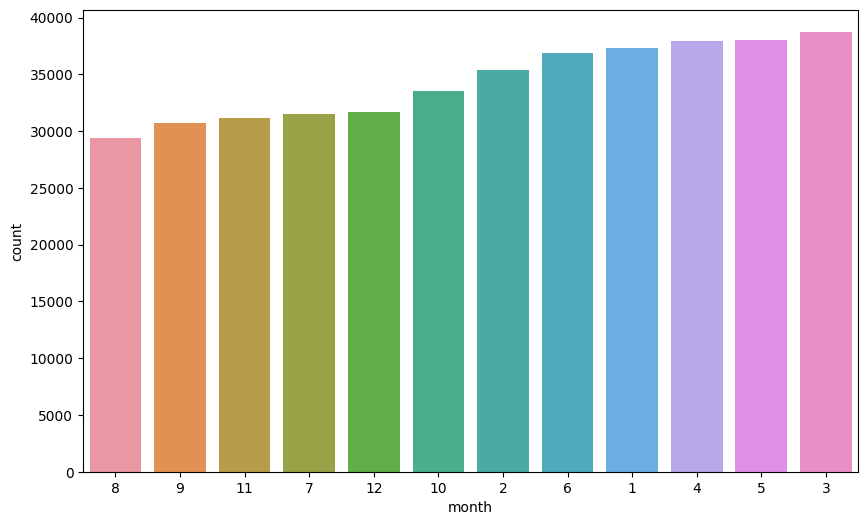

In [254]:
plt.figure(figsize=(10,6))
sns.countplot(x= data["month"], order=data['month'].value_counts(ascending=True).index)
plt.show()

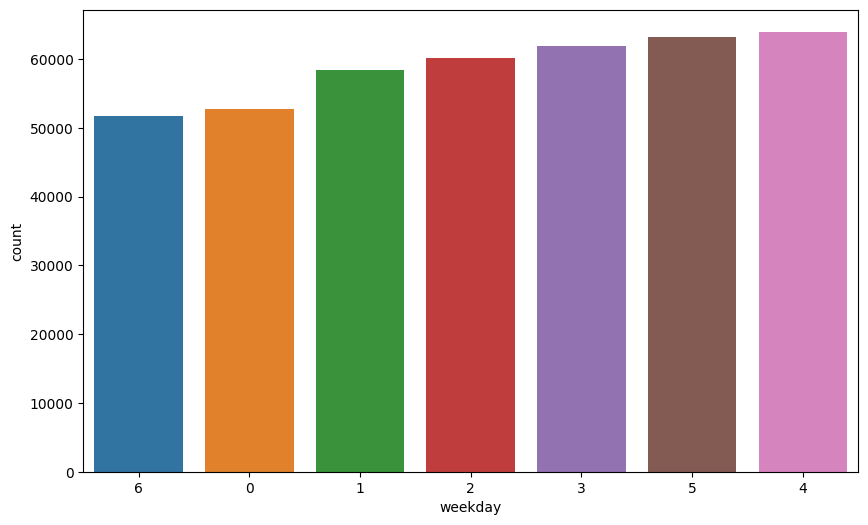

In [255]:
plt.figure(figsize=(10,6))
sns.countplot(x= data["weekday"], order=data['weekday'].value_counts(ascending=True).index)
plt.show()

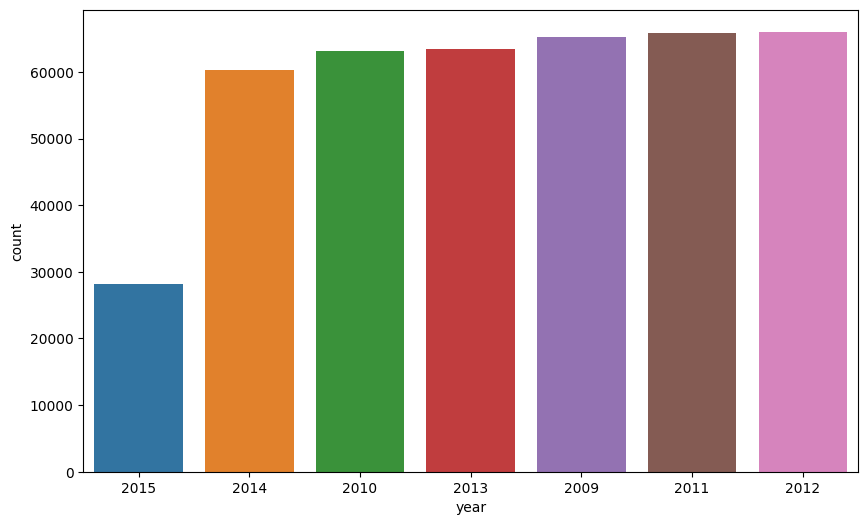

In [256]:
plt.figure(figsize=(10,6))
sns.countplot(x= data["year"], order=data['year'].value_counts(ascending=True).index)
plt.show()

## Visualization

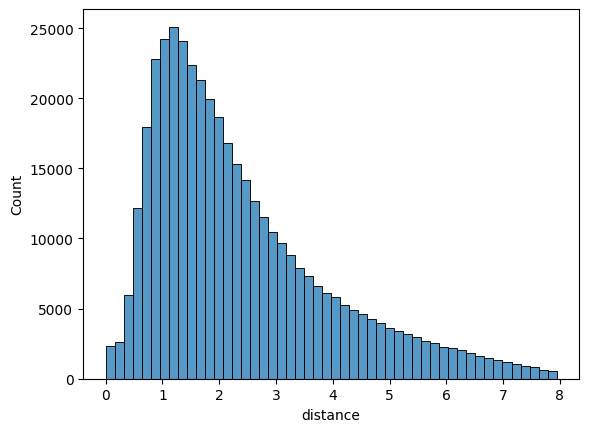

In [257]:
sns.histplot(x= "distance", bins=50,data= data)
plt.show()

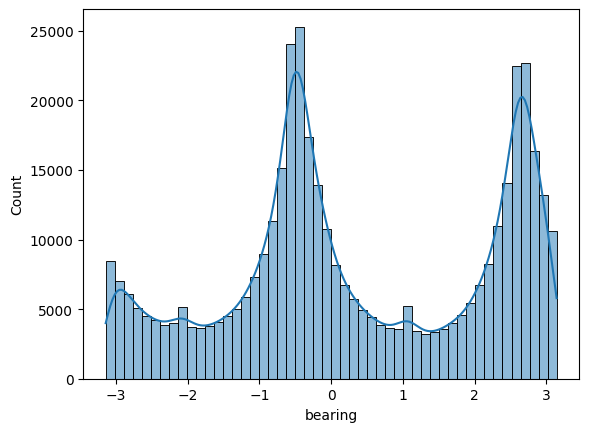

In [258]:
sns.histplot(x= "bearing", bins=50, kde= True,data= data)
plt.show()

## Categorical Features with Discrete Features and Target

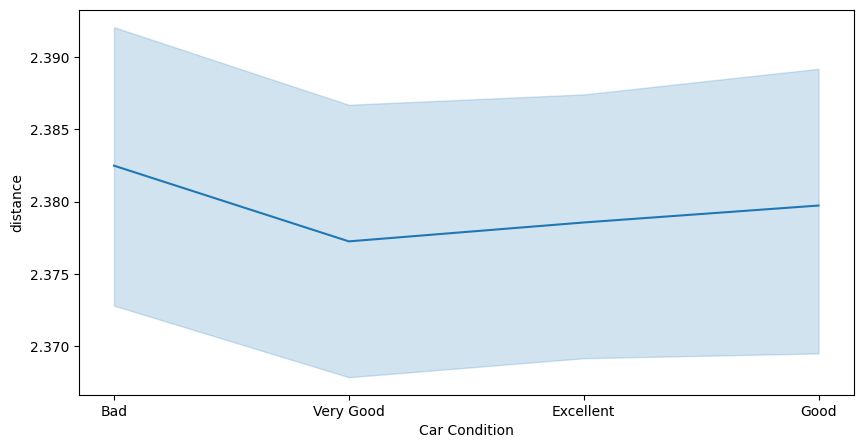

In [259]:
plt.figure(figsize=(10,5))
sns.lineplot(x= data["Car Condition"], y= data["distance"])
plt.show()

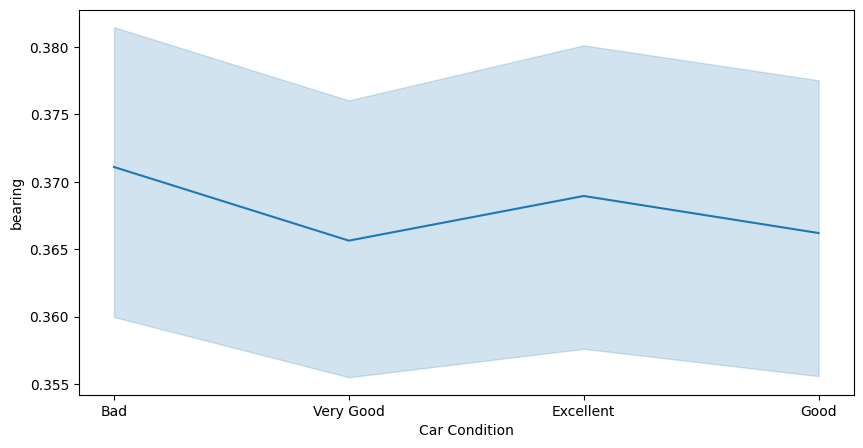

In [260]:
plt.figure(figsize=(10,5))
sns.lineplot(x= data["Car Condition"], y= data["bearing"])
plt.show()

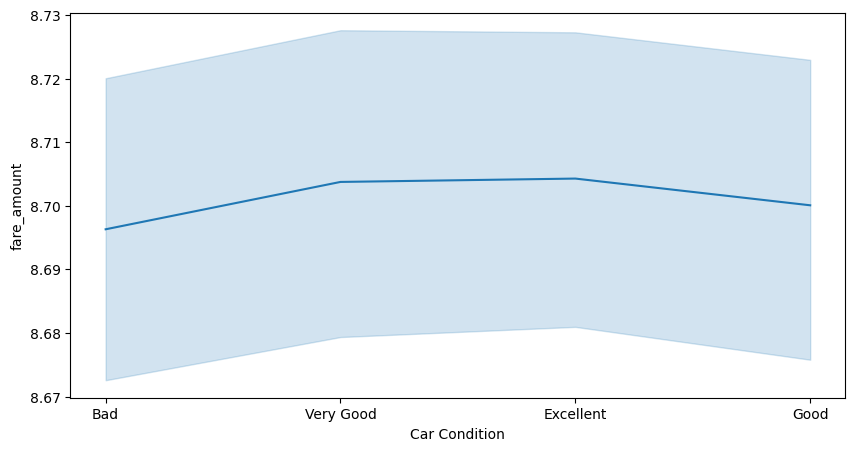

In [261]:
plt.figure(figsize=(10,5))
sns.lineplot(x= data["Car Condition"], y= data["fare_amount"])
plt.show()

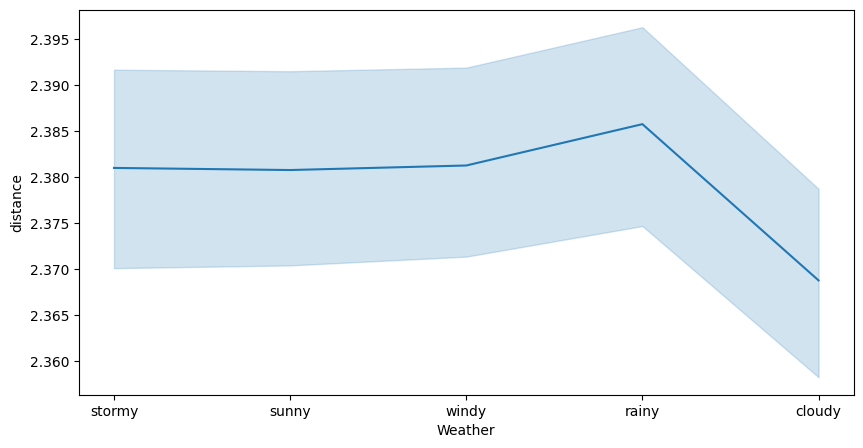

In [262]:
plt.figure(figsize=(10,5))
sns.lineplot(x= data["Weather"], y= data["distance"])
plt.show()

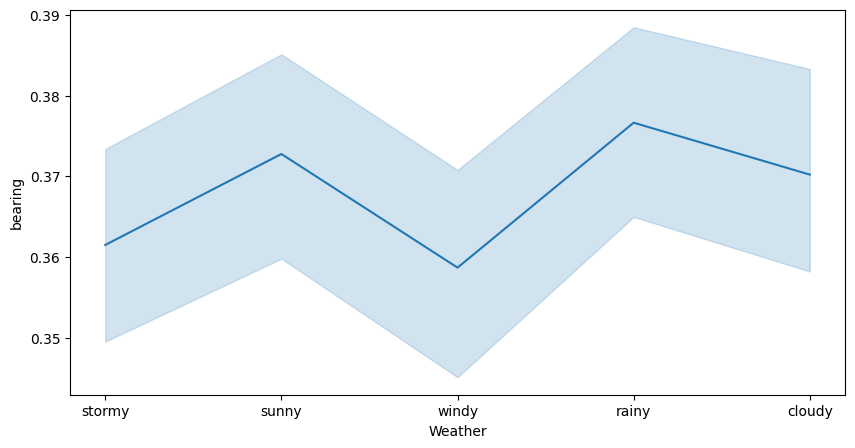

In [263]:
plt.figure(figsize=(10,5))
sns.lineplot(x= data["Weather"], y= data["bearing"])
plt.show()

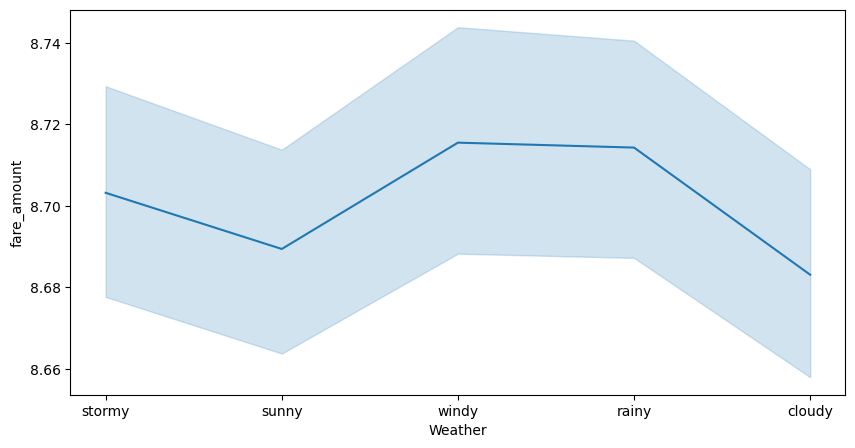

In [264]:
plt.figure(figsize=(10,5))
sns.lineplot(x= data["Weather"], y= data["fare_amount"])
plt.show()

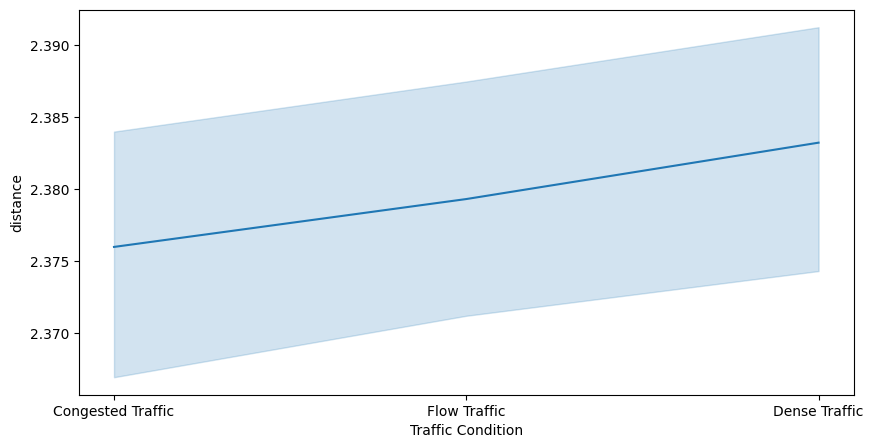

In [265]:
plt.figure(figsize=(10,5))
sns.lineplot(x= data["Traffic Condition"], y= data["distance"])
plt.show()

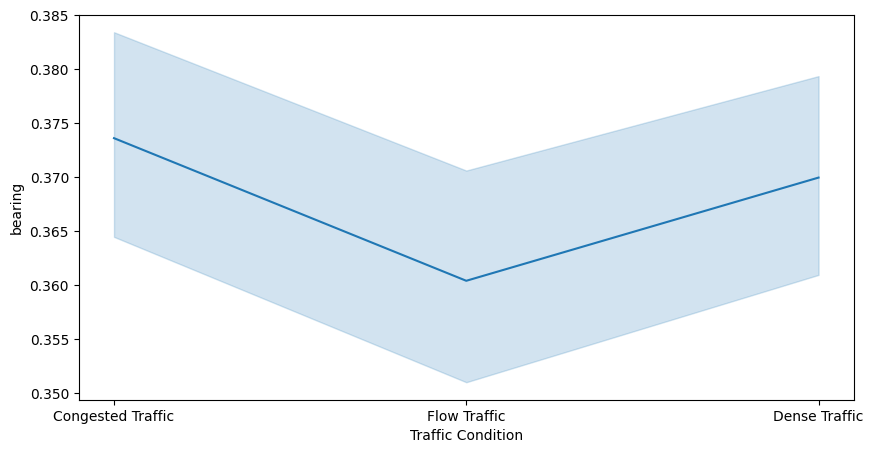

In [266]:
plt.figure(figsize=(10,5))
sns.lineplot(x= data["Traffic Condition"], y= data["bearing"])
plt.show()

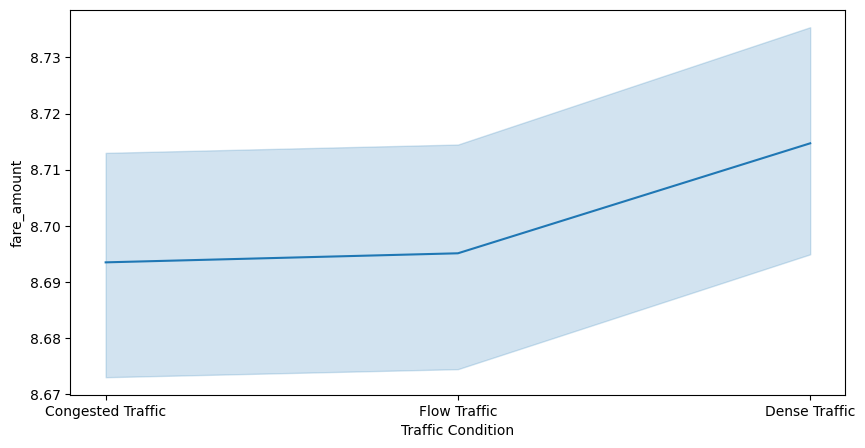

In [267]:
plt.figure(figsize=(10,5))
sns.lineplot(x= data["Traffic Condition"], y= data["fare_amount"])
plt.show()

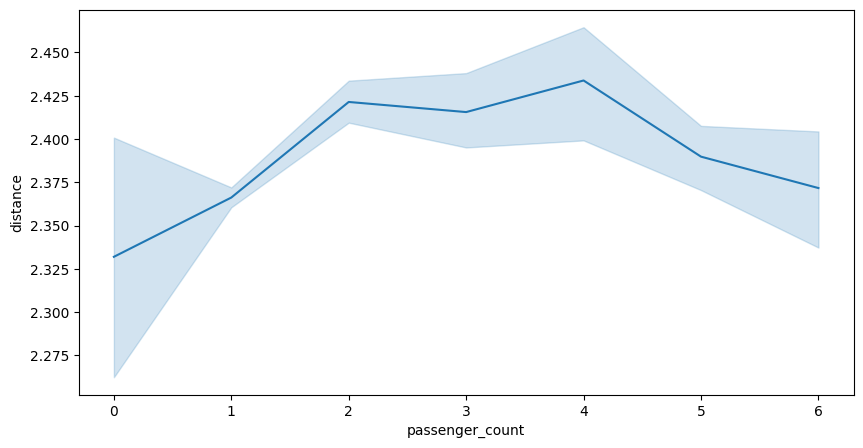

In [268]:
plt.figure(figsize=(10,5))
sns.lineplot(x= data["passenger_count"], y= data["distance"])
plt.show()

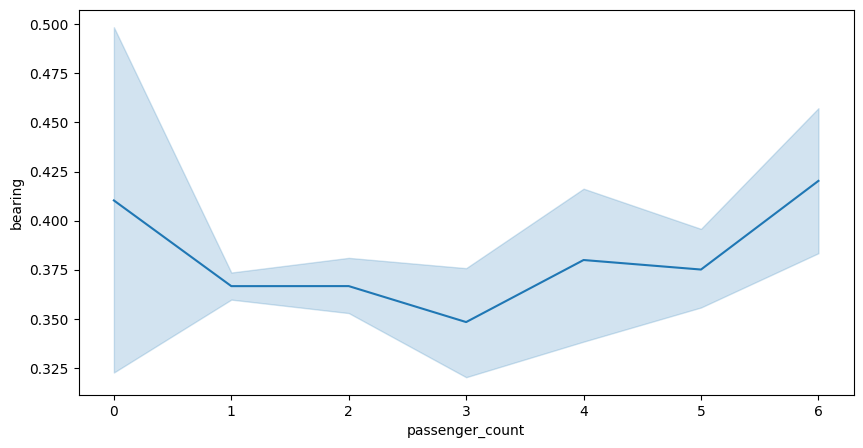

In [269]:
plt.figure(figsize=(10,5))
sns.lineplot(x= data["passenger_count"], y= data["bearing"])
plt.show()

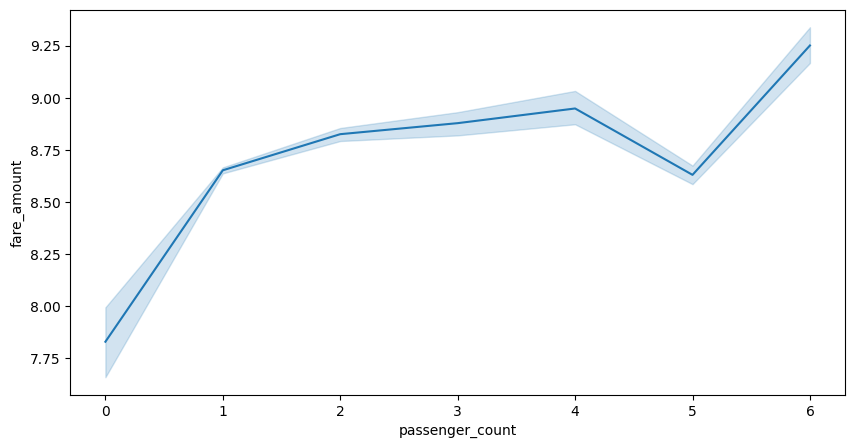

In [270]:
plt.figure(figsize=(10,5))
sns.lineplot(x= data["passenger_count"], y= data["fare_amount"])
plt.show()

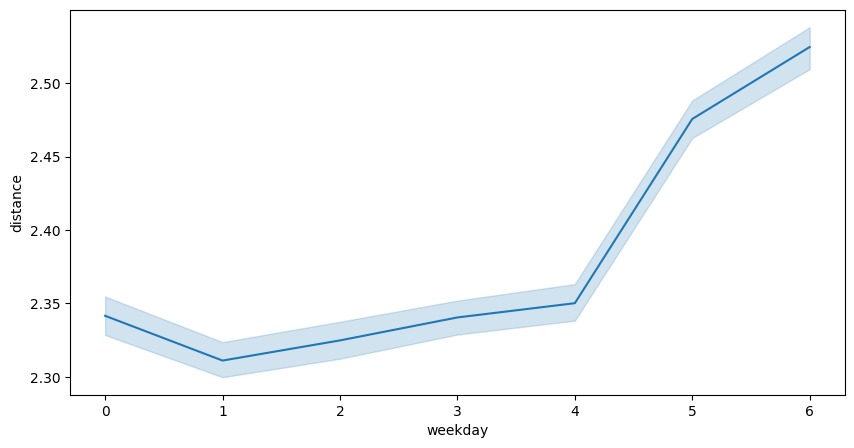

In [271]:
plt.figure(figsize=(10,5))
sns.lineplot(x= data["weekday"], y= data["distance"])
plt.show()

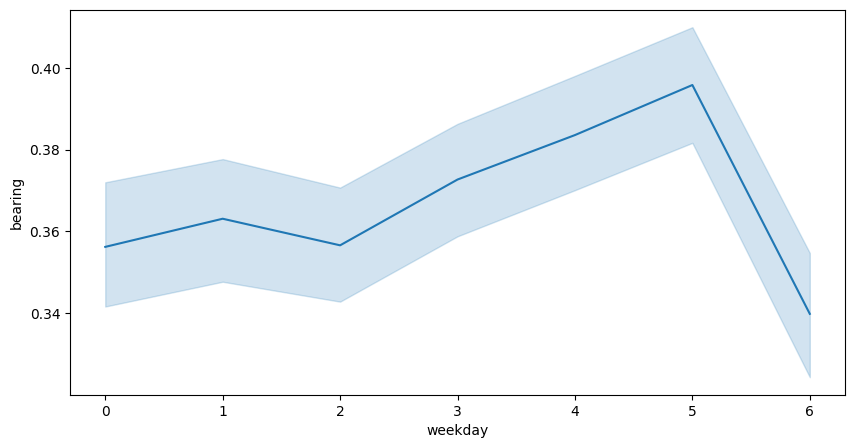

In [272]:
plt.figure(figsize=(10,5))
sns.lineplot(x= data["weekday"], y= data["bearing"])
plt.show()

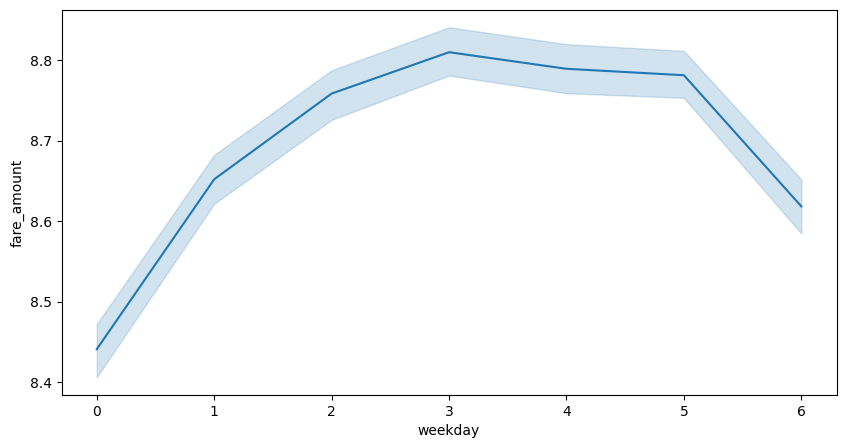

In [273]:
plt.figure(figsize=(10,5))
sns.lineplot(x= data["weekday"], y= data["fare_amount"])
plt.show()

In [274]:
data.reset_index(inplace=True, drop= True)

## Label Encoding

In [275]:
data[["Car Condition", "Weather", "Traffic Condition", "passenger_count","year"]]= data[["Car Condition", "Weather", "Traffic Condition", "passenger_count","year"]].apply(LabelEncoder().fit_transform)

<Axes: >

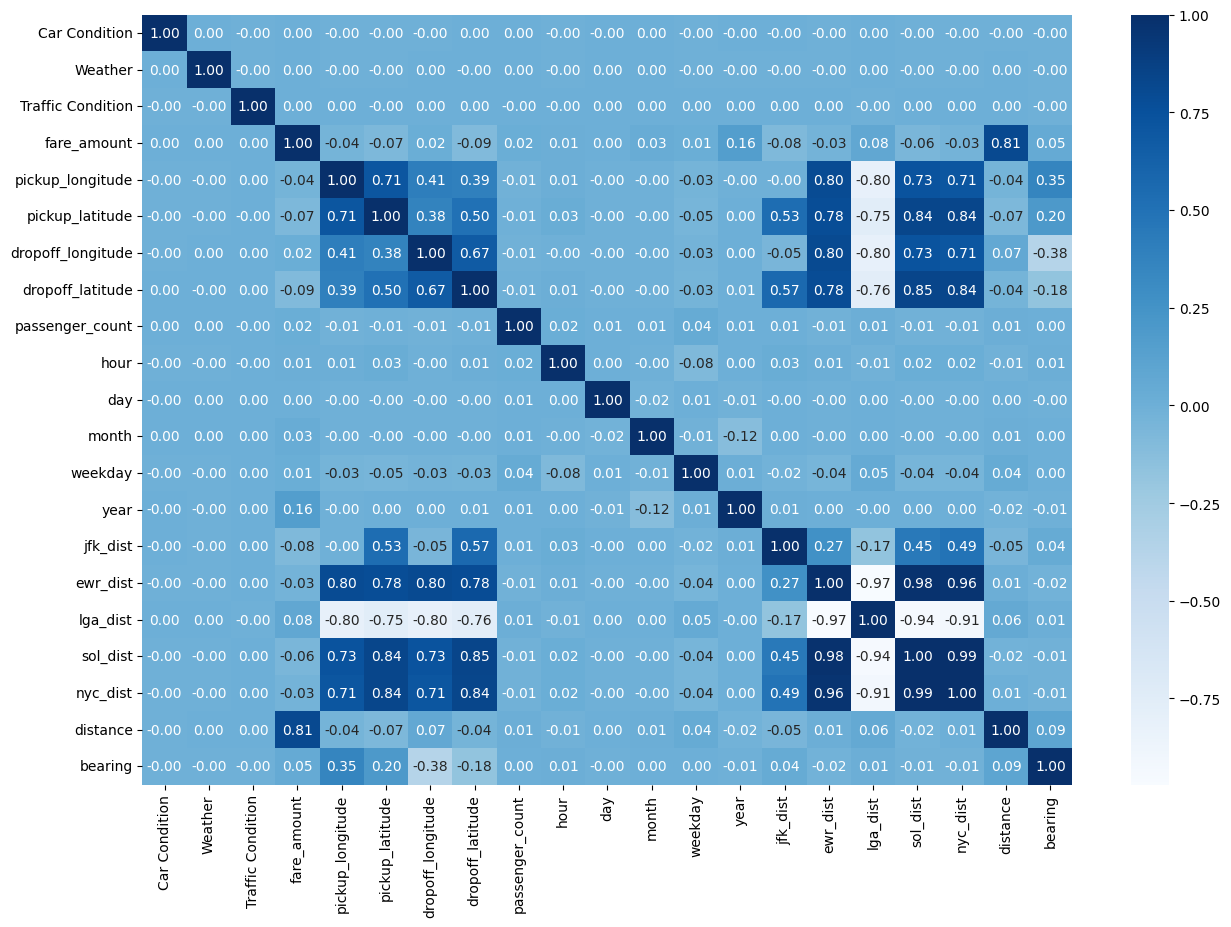

In [276]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), annot=True, cmap="Blues", fmt=".2f")

## Normalization

In [277]:
data_cols= data.columns

In [278]:
normalize = MinMaxScaler()
normalize.fit(data)

MinMaxScaler()

In [279]:
data= normalize.transform(data)
data= pd.DataFrame(data, columns= data_cols)

In [280]:
data

,Car Condition,Weather,Traffic Condition,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,...,month,weekday,year,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist,distance,bearing
0,0.000000,0.50,0.0,0.345238,0.463573,0.559275,0.361424,0.504966,0.333333,0.000000,...,0.636364,0.500000,0.333333,0.605995,0.417344,0.509274,0.444174,0.388941,0.174933,0.913796
1,1.000000,0.50,1.0,0.424603,0.439395,0.406193,0.359466,0.545132,0.166667,0.173913,...,0.272727,0.833333,0.500000,0.507839,0.368287,0.568190,0.372520,0.303012,0.352422,0.521307
2,0.000000,0.50,0.0,0.329365,0.544183,0.595946,0.569767,0.682059,0.166667,0.304348,...,0.181818,0.166667,0.166667,0.578469,0.659059,0.280763,0.661261,0.619536,0.251686,0.419987
3,0.333333,0.75,0.0,0.599206,0.363238,0.397958,0.471960,0.545884,0.166667,0.391304,...,0.000000,0.500000,0.333333,0.476241,0.379689,0.547781,0.372598,0.300853,0.476809,0.392684
4,0.333333,1.00,1.0,0.416667,0.478635,0.506983,0.466478,0.581137,0.166667,0.869565,...,0.909091,0.166667,0.500000,0.499642,0.492495,0.423122,0.494892,0.434864,0.195868,0.445522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412282,1.000000,1.00,0.0,0.634921,0.433645,0.488948,0.385509,0.442674,0.833333,0.956522,...,0.000000,0.833333,1.000000,0.454455,0.368355,0.555514,0.361958,0.286280,0.132853,0.011828
412283,0.000000,0.25,0.5,0.396825,0.485390,0.588956,0.513041,0.547507,0.166667,0.782609,...,0.363636,0.500000,1.000000,0.499865,0.539075,0.376092,0.540926,0.486449,0.176844,0.137802
412284,1.000000,0.25,1.0,0.662698,0.352405,0.325997,0.251792,0.293681,0.166667,0.521739,...,0.727273,0.000000,0.166667,0.422702,0.167824,0.833791,0.114523,0.034132,0.125159,0.906947
412285,0.666667,0.50,0.0,0.376984,0.508280,0.533377,0.488270,0.580919,1.000000,0.521739,...,0.000000,0.000000,1.000000,0.471850,0.530704,0.379518,0.526671,0.467995,0.125195,0.438749


## Features

In [281]:
features = data.loc[:, ~data.columns.isin(["fare_amount"])]
features

,Car Condition,Weather,Traffic Condition,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist,distance,bearing
0,0.000000,0.50,0.0,0.463573,0.559275,0.361424,0.504966,0.333333,0.000000,0.566667,0.636364,0.500000,0.333333,0.605995,0.417344,0.509274,0.444174,0.388941,0.174933,0.913796
1,1.000000,0.50,1.0,0.439395,0.406193,0.359466,0.545132,0.166667,0.173913,0.666667,0.272727,0.833333,0.500000,0.507839,0.368287,0.568190,0.372520,0.303012,0.352422,0.521307
2,0.000000,0.50,0.0,0.544183,0.595946,0.569767,0.682059,0.166667,0.304348,0.266667,0.181818,0.166667,0.166667,0.578469,0.659059,0.280763,0.661261,0.619536,0.251686,0.419987
3,0.333333,0.75,0.0,0.363238,0.397958,0.471960,0.545884,0.166667,0.391304,0.166667,0.000000,0.500000,0.333333,0.476241,0.379689,0.547781,0.372598,0.300853,0.476809,0.392684
4,0.333333,1.00,1.0,0.478635,0.506983,0.466478,0.581137,0.166667,0.869565,0.633333,0.909091,0.166667,0.500000,0.499642,0.492495,0.423122,0.494892,0.434864,0.195868,0.445522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412282,1.000000,1.00,0.0,0.433645,0.488948,0.385509,0.442674,0.833333,0.956522,0.766667,0.000000,0.833333,1.000000,0.454455,0.368355,0.555514,0.361958,0.286280,0.132853,0.011828
412283,0.000000,0.25,0.5,0.485390,0.588956,0.513041,0.547507,0.166667,0.782609,0.200000,0.363636,0.500000,1.000000,0.499865,0.539075,0.376092,0.540926,0.486449,0.176844,0.137802
412284,1.000000,0.25,1.0,0.352405,0.325997,0.251792,0.293681,0.166667,0.521739,0.400000,0.727273,0.000000,0.166667,0.422702,0.167824,0.833791,0.114523,0.034132,0.125159,0.906947
412285,0.666667,0.50,0.0,0.508280,0.533377,0.488270,0.580919,1.000000,0.521739,0.366667,0.000000,0.000000,1.000000,0.471850,0.530704,0.379518,0.526671,0.467995,0.125195,0.438749


## Target

In [282]:
target = data.loc[:, data.columns.isin(["fare_amount"])]
target

,fare_amount
0,0.345238
1,0.424603
2,0.329365
3,0.599206
4,0.416667
...,...
412282,0.634921
412283,0.396825
412284,0.662698
412285,0.376984


In [283]:
features.columns = features.columns.astype(str)

## train_test_split

In [284]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.33, random_state=42)

In [285]:
X_train

,Car Condition,Weather,Traffic Condition,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist,distance,bearing
358516,0.000000,0.25,0.5,0.555937,0.564581,0.624745,0.690183,0.166667,0.913043,0.033333,0.636364,1.000000,0.000000,0.480894,0.686280,0.240811,0.668304,0.622427,0.377117,0.413320
241361,0.000000,1.00,0.5,0.531731,0.575368,0.346329,0.527711,0.166667,1.000000,0.533333,0.818182,0.666667,0.833333,0.590150,0.463361,0.459819,0.486021,0.434550,0.280783,0.827617
170094,0.333333,0.00,1.0,0.600588,0.664136,0.549937,0.569968,0.166667,0.913043,0.066667,0.000000,0.833333,0.000000,0.466205,0.663749,0.255999,0.647618,0.599761,0.250020,0.985820
290133,1.000000,0.00,0.0,0.452943,0.475748,0.353069,0.530266,0.166667,0.739130,0.333333,0.181818,0.166667,0.833333,0.556867,0.386835,0.538430,0.404609,0.342805,0.156124,0.590907
366636,0.333333,0.00,0.5,0.416467,0.417137,0.259749,0.475922,0.166667,0.695652,0.100000,0.545455,0.500000,0.666667,0.587654,0.277446,0.663338,0.299991,0.238844,0.226502,0.644405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,0.666667,1.00,0.5,0.638000,0.739939,0.581555,0.657111,0.333333,0.695652,0.233333,1.000000,0.833333,0.500000,0.642141,0.768506,0.210505,0.766363,0.735836,0.218742,0.971738
365838,0.666667,0.25,1.0,0.544321,0.565316,0.480351,0.510455,0.166667,0.739130,0.033333,0.818182,0.833333,0.166667,0.384140,0.534112,0.368863,0.513801,0.449294,0.155347,0.962396
131932,0.000000,0.25,0.0,0.463491,0.374664,0.415945,0.593923,0.166667,0.608696,0.466667,0.909091,0.833333,0.833333,0.441994,0.425703,0.521060,0.412899,0.343627,0.558452,0.498297
146867,0.333333,1.00,0.0,0.399814,0.447322,0.401030,0.488793,0.166667,0.739130,0.500000,1.000000,0.000000,0.666667,0.487135,0.357508,0.566400,0.357912,0.285140,0.140080,0.369565


## Random Forest

In [286]:
RF = RandomForestRegressor(n_estimators=100, 
                            random_state= 42, 
                            n_jobs= -1)
RF.fit(X_train, np.ravel(y_train))

RandomForestRegressor(n_jobs=-1, random_state=42)

In [287]:
rf_pred= RF.predict(X_test)
mean_squared_error(y_test, rf_pred)

0.0049524011600000474

## Linear Regression

In [288]:
LR= LinearRegression()
LR.fit(X_train, y_train)

LinearRegression()

In [289]:
lr_pred= LR.predict(X_test)
mean_squared_error(y_test, lr_pred)

0.0069844954278537805

## Polynomial

In [290]:
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.fit_transform(X_test)


model = LinearRegression()
model.fit(X_poly_train, np.ravel(y_train))

LinearRegression()

In [291]:
ploy_pred= model.predict(X_poly_test)
mean_squared_error(y_test, ploy_pred)

0.005867555309449332

## XGBRegressor

In [292]:
XG= xg.XGBRegressor()
XG.fit(X_train, np.ravel(y_train))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [293]:
xg_pred= XG.predict(X_test)
model_val2(XG,X_train,y_train, X_test, y_test)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) accuracy: 0.8073210448499472
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_me

## DecisionTreeRegressor

In [294]:
DT= DecisionTreeRegressor()
DT.fit(X_train, np.ravel(y_train))

DecisionTreeRegressor()

In [295]:
dt_pred= DT.predict(X_test)
mean_squared_error(y_test, dt_pred)

0.010483728497394627